# TODOs:

- final train and val loss (best)

# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [1171]:
#USE_COLAB = True
#
#if USE_COLAB:
#    from google.colab import drive
#
#    drive.mount('/content/drive')
#    import sys
#
#    sys.path.insert(1, r'/content/drive/My Drive/')

In [1172]:
USE_COLAB = False

In [1173]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [1174]:
# import sys
# sys.path.append("OM_project")

# Imports and Setup

In [1175]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import copy

from utils import ml_utils, visualization, data_loading, tf_models

In [1176]:
#RETRAIN_FLAG = True
RETRAIN_FLAG = False

In [1177]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [1178]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [1179]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive, rho)
    model.load_weights(filename)
    return model

In [1180]:
def build_and_load_model_weights(train, optimizer, filename):
    model = tf_models.build_and_compile_simple_cnn(train, optimizer)
    model.load_weights(filename)
    return model

In [1181]:
def callback_for_filename(filename):
    train_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filename,
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        )
    ]

    return train_callbacks

In [1182]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()
# dataset_name = 'MNIST'
dataset_name = 'Fashion_MNIST'
EPOCHS = 500

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of accelerators:  1


In [1183]:
models = {}
models_states = {}
sharpnesses = ml_utils.init_sharpnesses_dict()
initial_weights = ml_utils.init_initial_weights_dict()

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [1184]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'sam')

In [1185]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models[key + (batch_size,)] = model

In [1186]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
            initial_weights[key + (batch_size,)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1187]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [1188]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_state_filename)

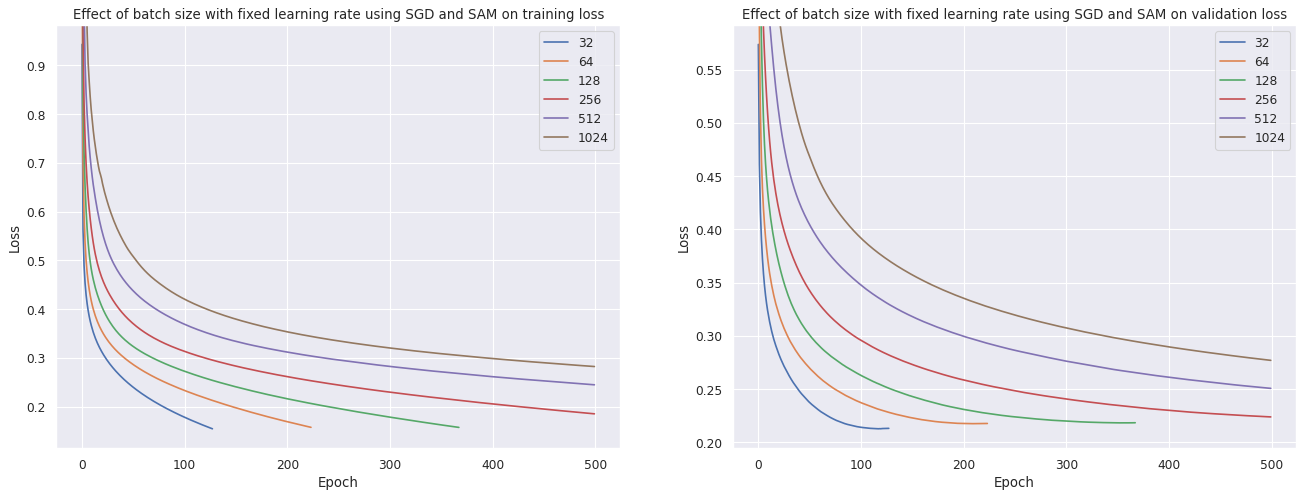

In [1189]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate using SGD and SAM', 'fixed_lr_diff_bs_SGD_SAM')

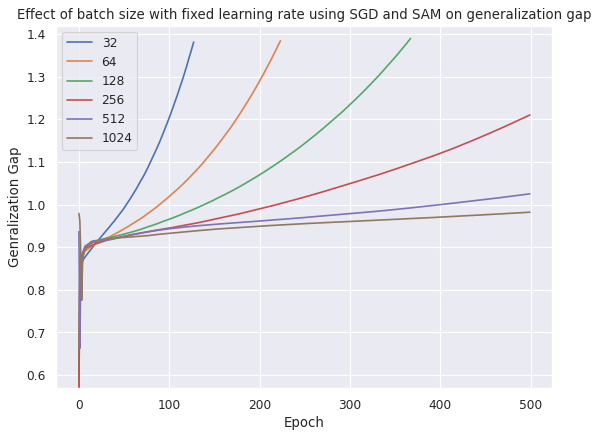

In [1190]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with fixed learning rate using SGD and SAM', 'fixed_lr_diff_bs_SGD_SAM_gap')

#### Sharpness

In [1191]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

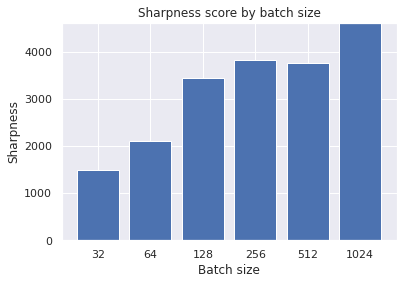

In [1192]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 18.081127166748047
Batch size: 64, distance: 17.10660171508789
Batch size: 128, distance: 15.535463333129883
Batch size: 256, distance: 13.078746795654297
Batch size: 512, distance: 9.540457725524902
Batch size: 1024, distance: 7.454821586608887


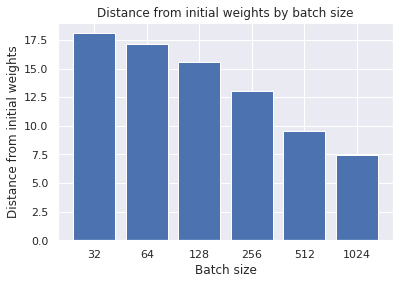

In [1193]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [1194]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.783301837742329
	Converged in 117 epochs
	Overall training time (in seconds) until convergence:  1140.053561449051
Batch size:  64
	Mean time per epoch:  4.96157372210707
	Converged in 213 epochs
	Overall training time (in seconds) until convergence:  1054.364414691925
Batch size:  128
	Mean time per epoch:  3.386546772459279
	Converged in 357 epochs
	Overall training time (in seconds) until convergence:  1209.4030270576477
Batch size:  256
	Mean time per epoch:  2.743571702957153
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1369.1250777244568
Batch size:  512
	Mean time per epoch:  2.348927083492279
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1171.9734966754913
Batch size:  1024
	Mean time per epoch:  2.1001287698745728
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1047.9715383052826


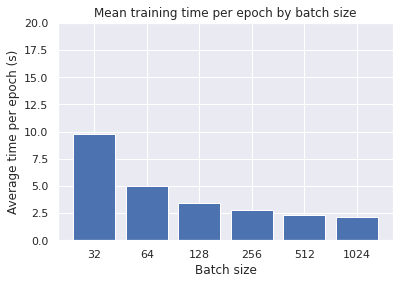

In [1195]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

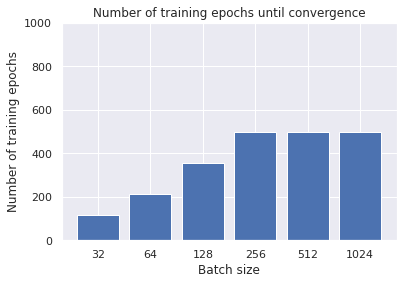

In [1196]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

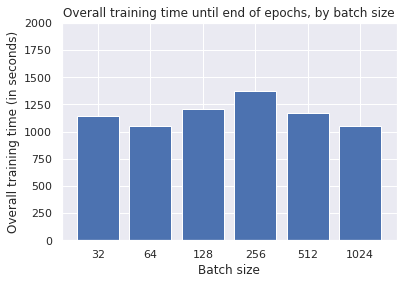

In [1197]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

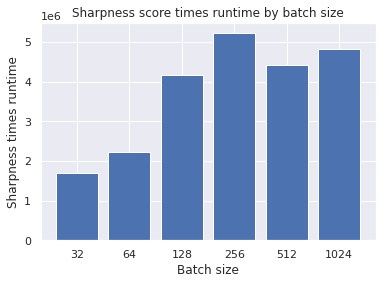

In [1198]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### SGD with Momentum + ASAM

In [1199]:
models_dict_fixed_sgd_asam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'asam')

In [1200]:
models_by_batch_size_fixed_lr_sgd_asam = {}

In [1201]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model

In [1202]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
            initial_weights[key + (batch_size,)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1203]:
fixed_lr_sgd_asam_state_filename = 'model_fixed_lr_diff_bs_sgd_asam_state'

In [1204]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_sgd_asam_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)

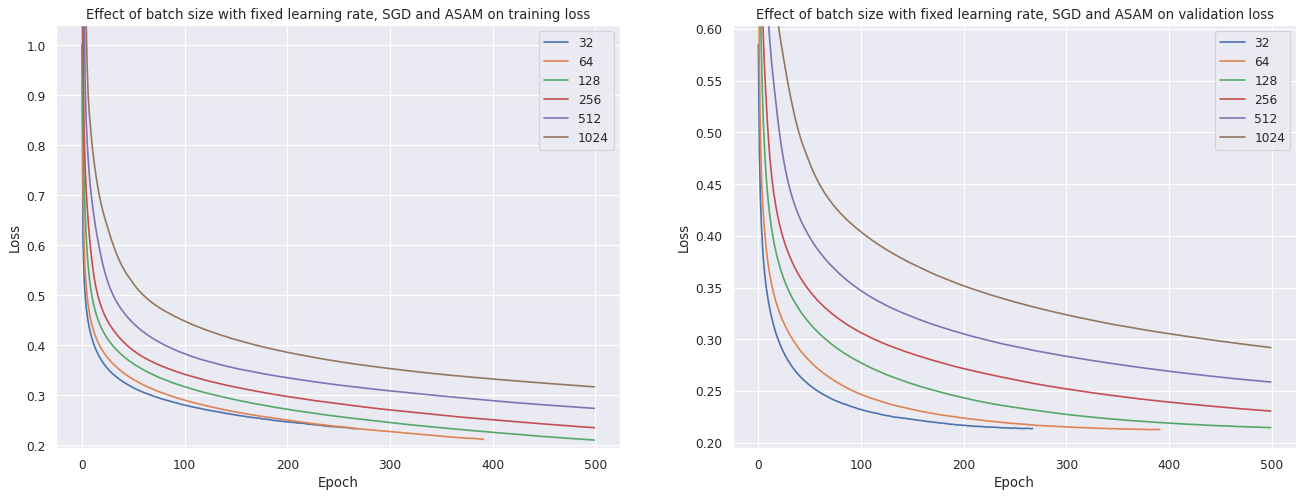

In [1205]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM',
                                 'model_fixed_lr_diff_bs_sgd_asam_state')

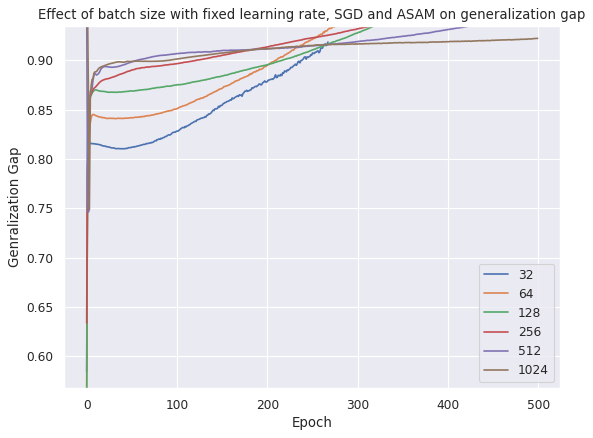

In [1206]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM', 'model_fixed_lr_diff_bs_sgd_asam_state_gap')

#### Sharpness

In [1207]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

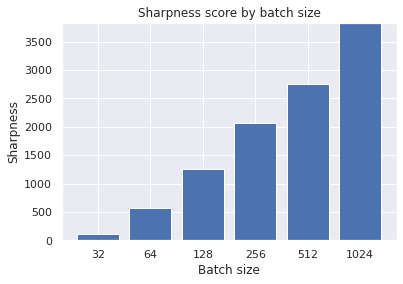

In [1208]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 26.044921875
Batch size: 64, distance: 22.652175903320312
Batch size: 128, distance: 18.935028076171875
Batch size: 256, distance: 14.037514686584473
Batch size: 512, distance: 10.44161605834961
Batch size: 1024, distance: 7.981127738952637


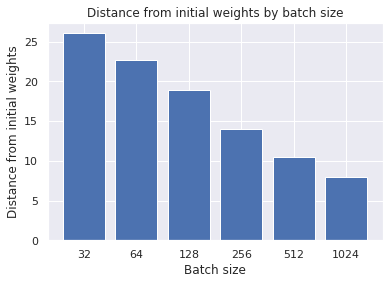

In [1209]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [1210]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.596336975026487
	Converged in 257 epochs
	Overall training time (in seconds) until convergence:  2469.926399230957
Batch size:  64
	Mean time per epoch:  5.120018089912375
	Converged in 381 epochs
	Overall training time (in seconds) until convergence:  1939.9005000591278
Batch size:  128
	Mean time per epoch:  3.224577534198761
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1609.2112636566162
Batch size:  256
	Mean time per epoch:  2.7158609366416933
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1355.0477526187897
Batch size:  512
	Mean time per epoch:  2.3651131086349486
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1180.1741573810577
Batch size:  1024
	Mean time per epoch:  2.498190211772919
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1246.9721426963806


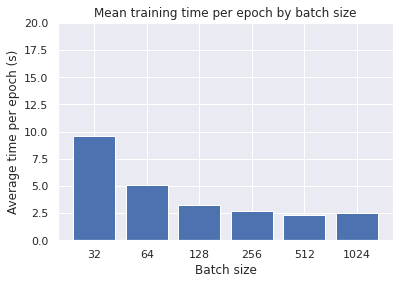

In [1211]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

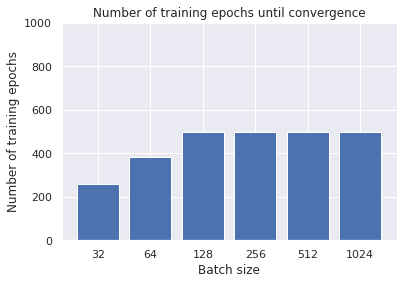

In [1212]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

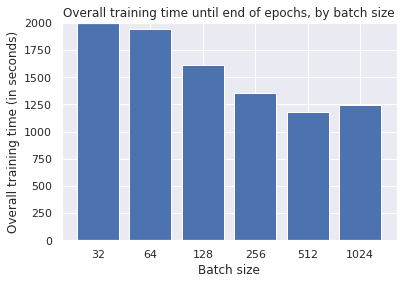

In [1213]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

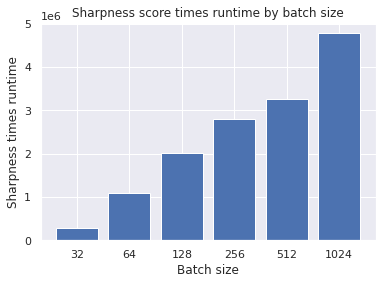

In [1214]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM + SAM

In [1215]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'sam')

In [1216]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
        models[key + (batch_size,)] = model

In [1217]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
            initial_weights[key + (batch_size,)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1218]:
state_filename = 'model_fixed_lr_diff_bs_adam_sam_state'

In [1219]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

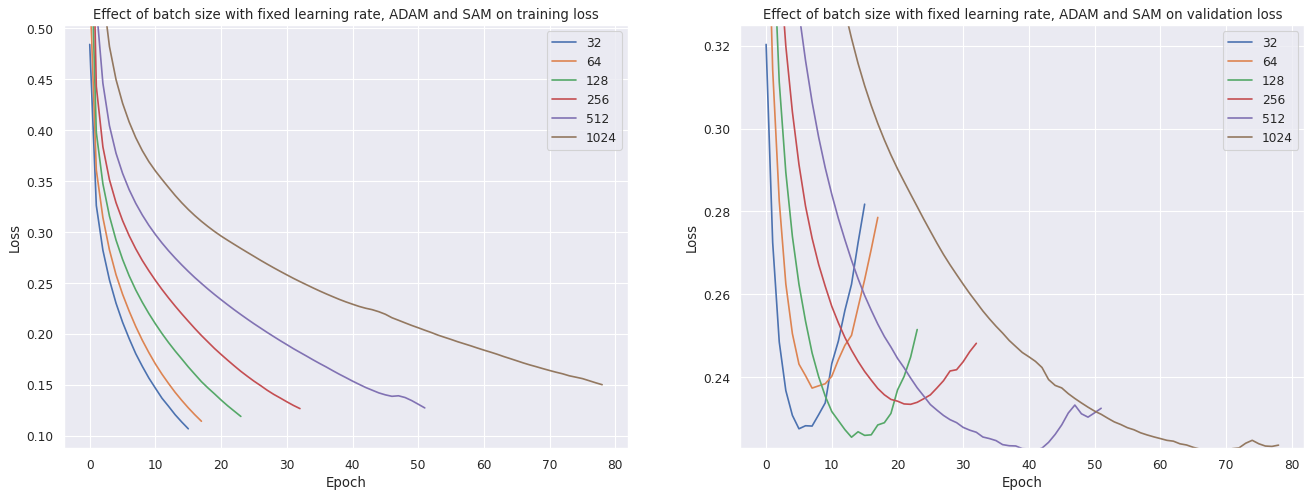

In [1220]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and SAM',
                                 state_filename)

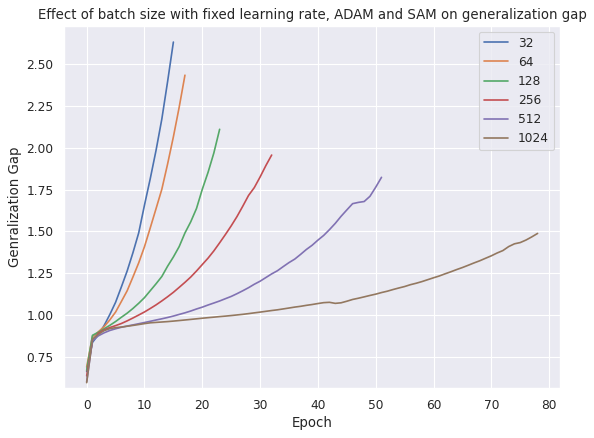

In [1221]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and SAM', state_filename+'gap')

#### Sharpness

In [1222]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

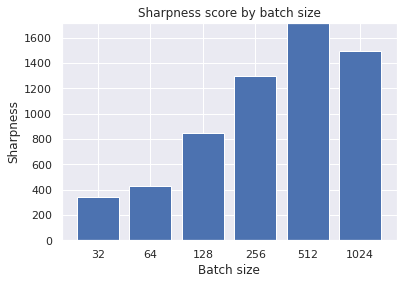

In [1223]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 31.690658569335938
Batch size: 64, distance: 27.07200050354004
Batch size: 128, distance: 27.04048728942871
Batch size: 256, distance: 25.984375
Batch size: 512, distance: 27.0130672454834
Batch size: 1024, distance: 24.098642349243164


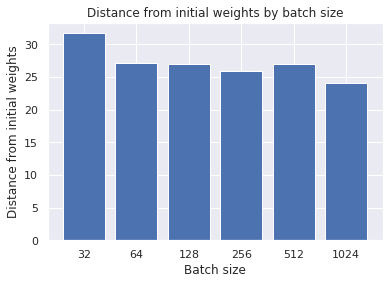

In [1224]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [1225]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.400800302624702
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  47.36273121833801
Batch size:  64
	Mean time per epoch:  4.769461260901557
	Converged in 7 epochs
	Overall training time (in seconds) until convergence:  33.922574281692505
Batch size:  128
	Mean time per epoch:  3.398729791243871
	Converged in 13 epochs
	Overall training time (in seconds) until convergence:  45.61024355888367
Batch size:  256
	Mean time per epoch:  2.7990297837690874
	Converged in 22 epochs
	Overall training time (in seconds) until convergence:  62.93431782722473
Batch size:  512
	Mean time per epoch:  2.367312958607307
	Converged in 41 epochs
	Overall training time (in seconds) until convergence:  97.34253668785095
Batch size:  1024
	Mean time per epoch:  2.1517996637127066
	Converged in 68 epochs
	Overall training time (in seconds) until convergence:  146.967303276062


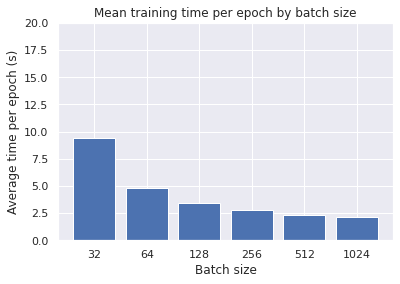

In [1226]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

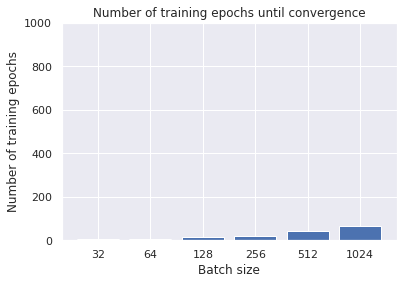

In [1227]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

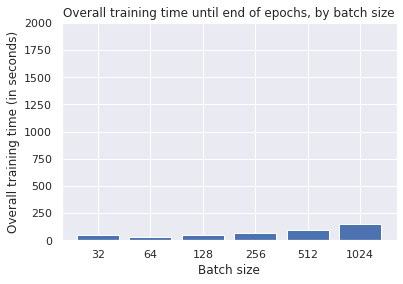

In [1228]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

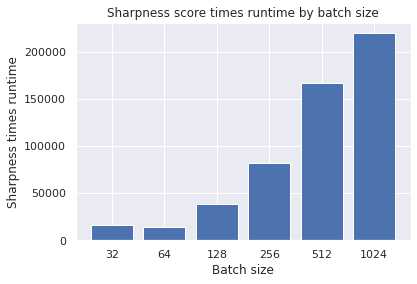

In [1229]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM + ASAM

In [1230]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'asam')

In [1231]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
        models[key + (batch_size,)] = model

In [1232]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
            initial_weights[key + (batch_size,)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1233]:
state_filename = 'model_fixed_lr_diff_bs_adam_asam_state'

In [1234]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

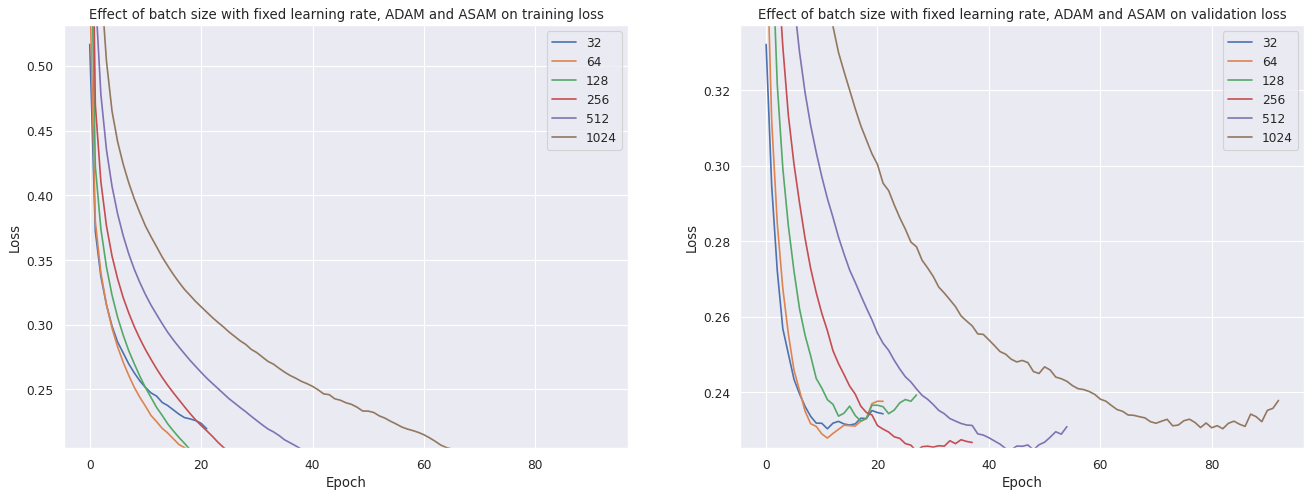

In [1235]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and ASAM',
                                 state_filename)

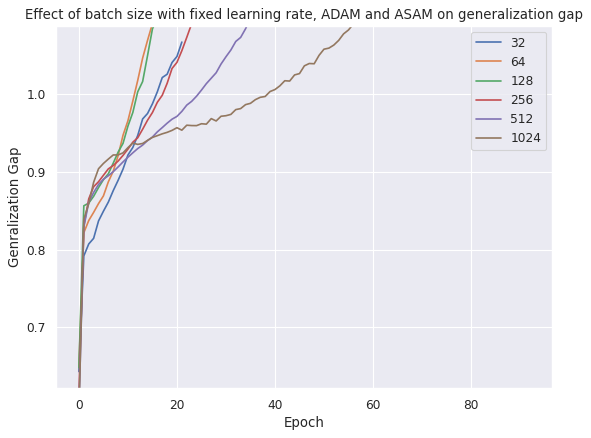

In [1236]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and ASAM', state_filename+'gap')

#### Sharpness

In [1237]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()


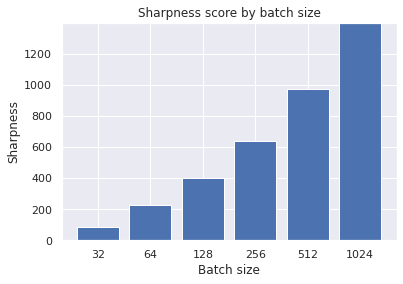

In [1238]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 53.20814895629883
Batch size: 64, distance: 36.05693817138672
Batch size: 128, distance: 31.077817916870117
Batch size: 256, distance: 28.03752326965332
Batch size: 512, distance: 25.86259651184082
Batch size: 1024, distance: 26.413049697875977


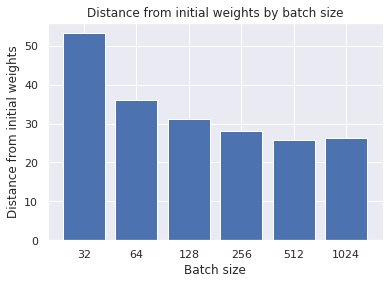

In [1239]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [1240]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  10.643075303597884
	Converged in 11 epochs
	Overall training time (in seconds) until convergence:  112.4361183643341
Batch size:  64
	Mean time per epoch:  5.810945857654918
	Converged in 11 epochs
	Overall training time (in seconds) until convergence:  65.70215249061584
Batch size:  128
	Mean time per epoch:  3.3506965807506015
	Converged in 17 epochs
	Overall training time (in seconds) until convergence:  57.285707235336304
Batch size:  256
	Mean time per epoch:  2.7365408006467318
	Converged in 27 epochs
	Overall training time (in seconds) until convergence:  74.48871445655823
Batch size:  512
	Mean time per epoch:  2.3069200299002905
	Converged in 44 epochs
	Overall training time (in seconds) until convergence:  102.0914855003357
Batch size:  1024
	Mean time per epoch:  2.1242232604693343
	Converged in 82 epochs
	Overall training time (in seconds) until convergence:  174.27104544639587


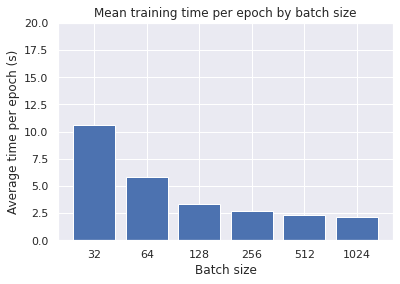

In [1241]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

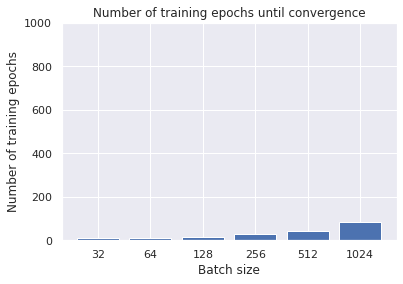

In [1242]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

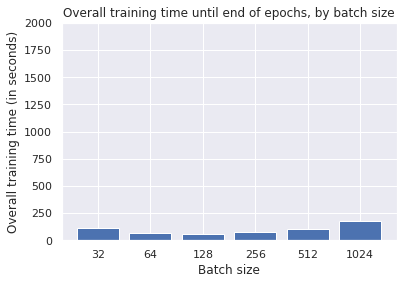

In [1243]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

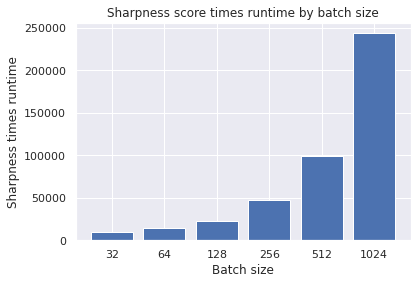

In [1244]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

## without sharpness aware minimization

### SGD with Momentum

In [1245]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'none')

In [1246]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
        models[key + (batch_size,)] = model

In [1247]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
            initial_weights[key + (batch_size,)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1248]:
state_filename = 'model_fixed_lr_diff_bs_noSAM_state'

In [1249]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

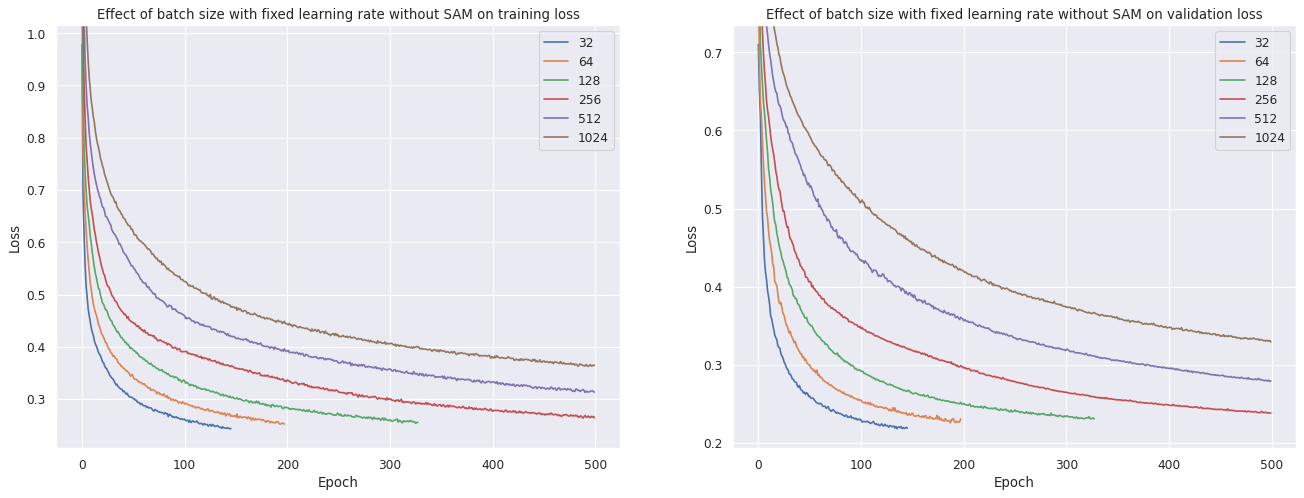

In [1250]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM',
                                 'fixed_lr_diff_bs_SGD_noSAM')

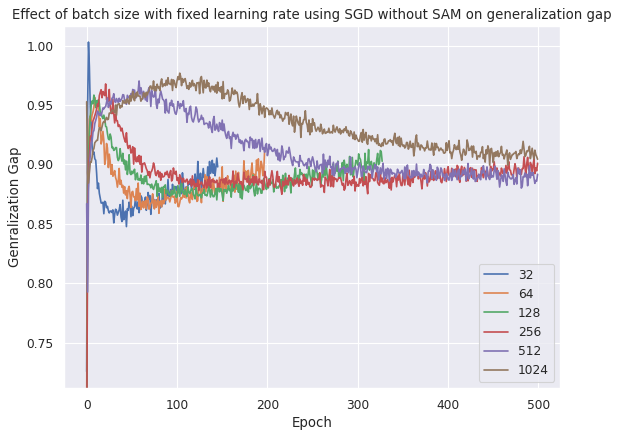

In [1251]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with fixed learning rate using SGD without SAM', 'fixed_lr_diff_bs_SGD_noSAM'+'gap')

#### Sharpness

In [1252]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

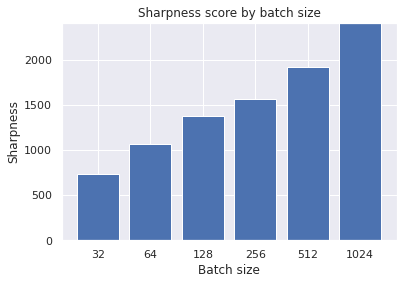

In [1253]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 17.341598510742188
Batch size: 64, distance: 14.87146282196045
Batch size: 128, distance: 13.737595558166504
Batch size: 256, distance: 12.385636329650879
Batch size: 512, distance: 9.583385467529297
Batch size: 1024, distance: 7.387922763824463


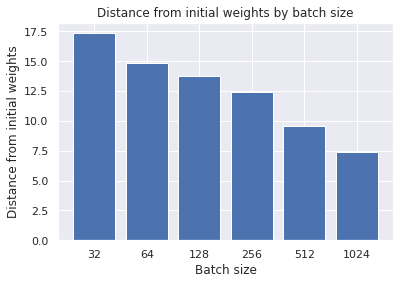

In [1254]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [1255]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.198763703646725
	Converged in 135 epochs
	Overall training time (in seconds) until convergence:  702.8068780899048
Batch size:  64
	Mean time per epoch:  2.855587231992471
	Converged in 187 epochs
	Overall training time (in seconds) until convergence:  534.5256180763245
Batch size:  128
	Mean time per epoch:  2.1113371216669314
	Converged in 317 epochs
	Overall training time (in seconds) until convergence:  669.3514122962952
Batch size:  256
	Mean time per epoch:  1.6842880606651307
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  840.4438276290894
Batch size:  512
	Mean time per epoch:  1.3907951736450195
	Converged in 498 epochs
	Overall training time (in seconds) until convergence:  692.6832709312439
Batch size:  1024
	Mean time per epoch:  1.216062165260315
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  606.8297348022461


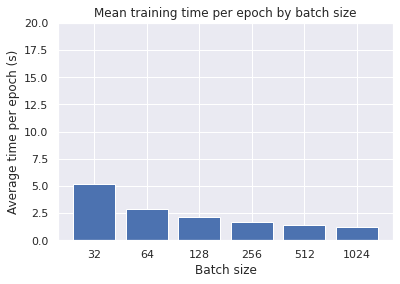

In [1256]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

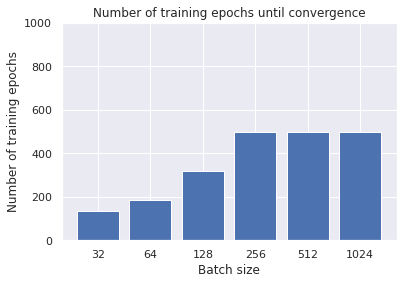

In [1257]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

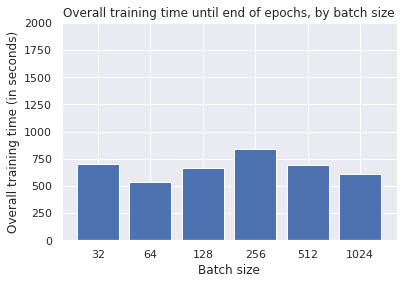

In [1258]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

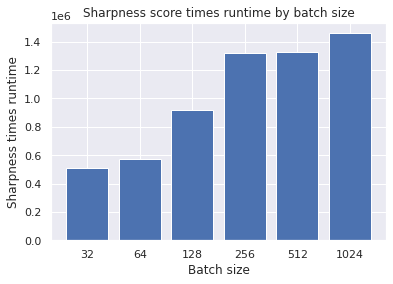

In [1259]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM

In [1260]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'none')

In [1261]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
        models[key + (batch_size,)] = model

In [1262]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
            initial_weights[key + (batch_size,)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1263]:
state_filename = 'model_fixed_lr_diff_bs_ADAM_noSAM_state'

In [1264]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

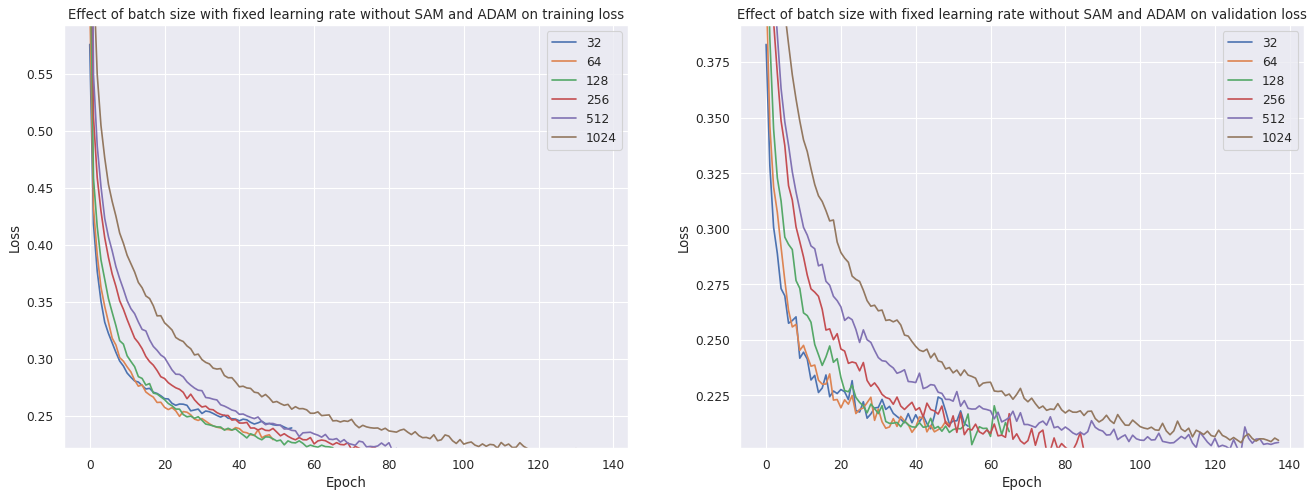

In [1265]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM and ADAM',
                                 'fixed_lr_diff_bs_ADAM_noSAM')

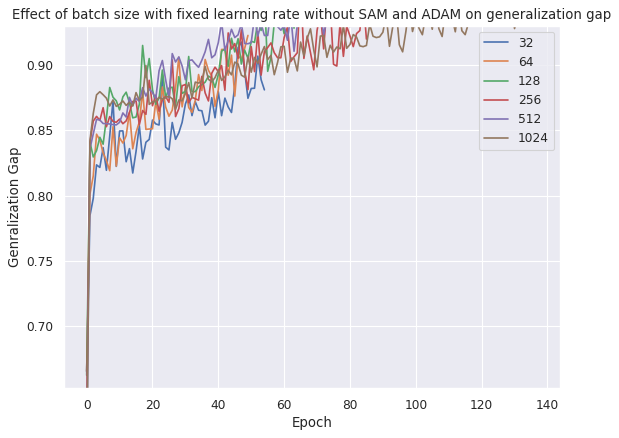

In [1266]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with fixed learning rate without SAM and ADAM', 'fixed_lr_diff_bs_ADAM_noSAM'+'gap')

#### Sharpness

In [1267]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

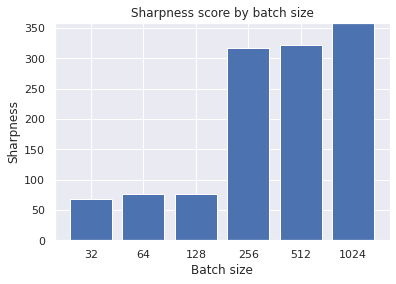

In [1268]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 83.09166717529297
Batch size: 64, distance: 57.523040771484375
Batch size: 128, distance: 51.449462890625
Batch size: 256, distance: 46.31904983520508
Batch size: 512, distance: 47.25518798828125
Batch size: 1024, distance: 37.453269958496094


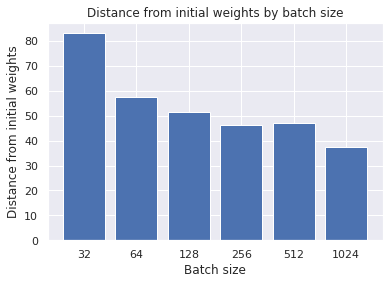

In [1269]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [1270]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.064963119680232
	Converged in 44 epochs
	Overall training time (in seconds) until convergence:  223.53365182876587
Batch size:  64
	Mean time per epoch:  2.8850979471206664
	Converged in 39 epochs
	Overall training time (in seconds) until convergence:  113.9300639629364
Batch size:  128
	Mean time per epoch:  2.0982076435378105
	Converged in 55 epochs
	Overall training time (in seconds) until convergence:  115.87813115119934
Batch size:  256
	Mean time per epoch:  1.7034937087879625
	Converged in 75 epochs
	Overall training time (in seconds) until convergence:  128.25968670845032
Batch size:  512
	Mean time per epoch:  1.3945307610691458
	Converged in 127 epochs
	Overall training time (in seconds) until convergence:  177.57358860969543
Batch size:  1024
	Mean time per epoch:  1.24144572969796
	Converged in 127 epochs
	Overall training time (in seconds) until convergence:  157.9004247188568


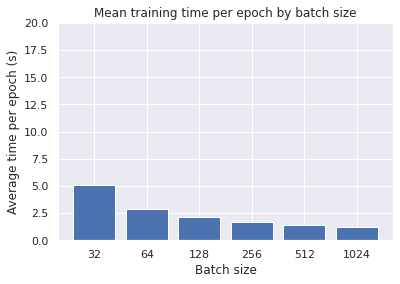

In [1271]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

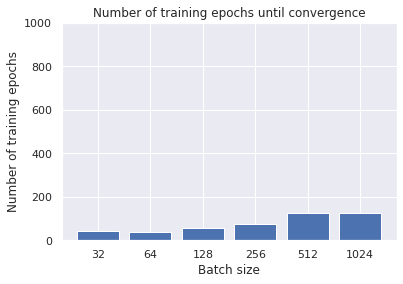

In [1272]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

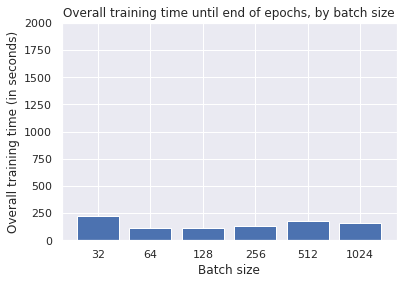

In [1273]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

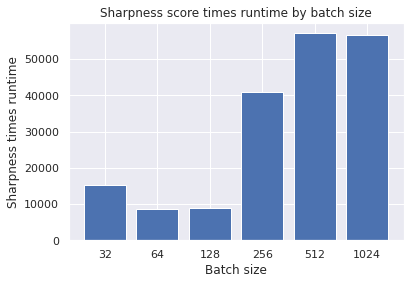

In [1274]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [1275]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'sam')

In [1276]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [1277]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [1278]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models[key + (batch_size, lr)] = model

In [1279]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
            initial_weights[key + (batch_size, lr)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1280]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], diff_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(diff_lr_state_filename)

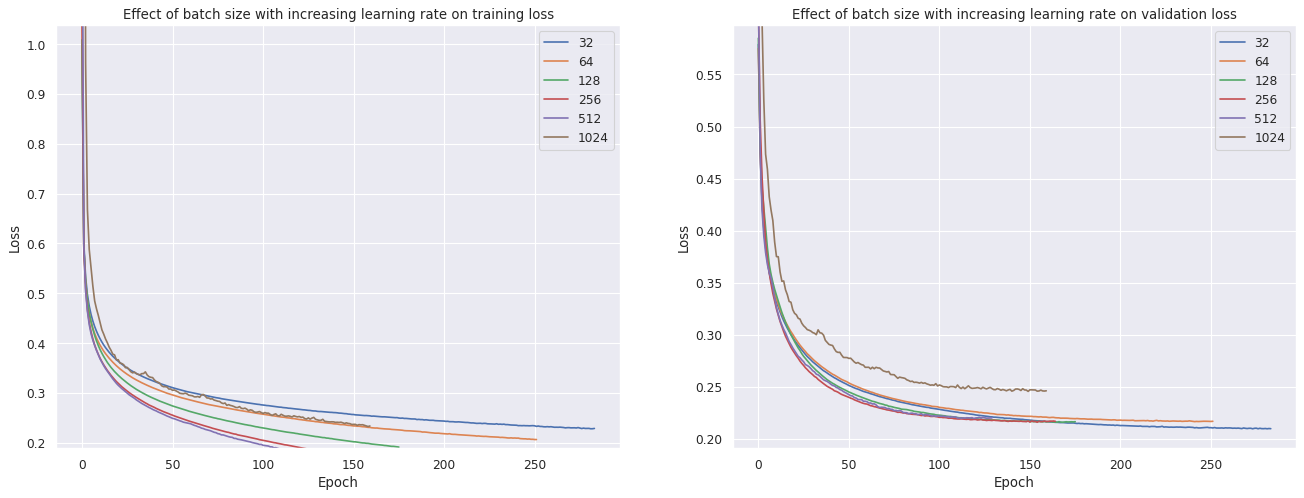

In [1281]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

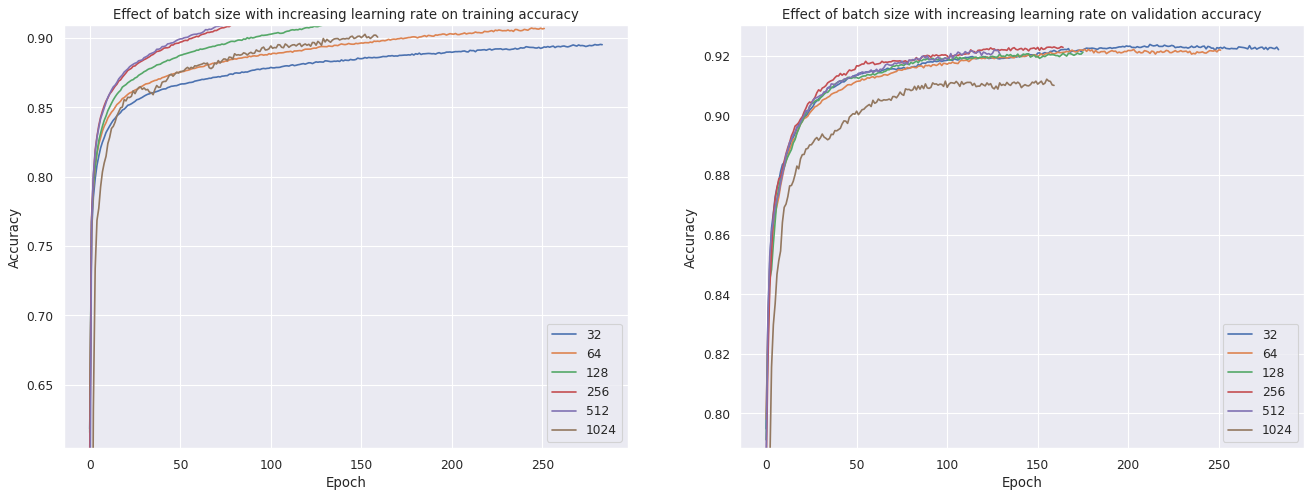

In [1282]:
visualization.plot_accuracies_by_param(models_states[key], 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

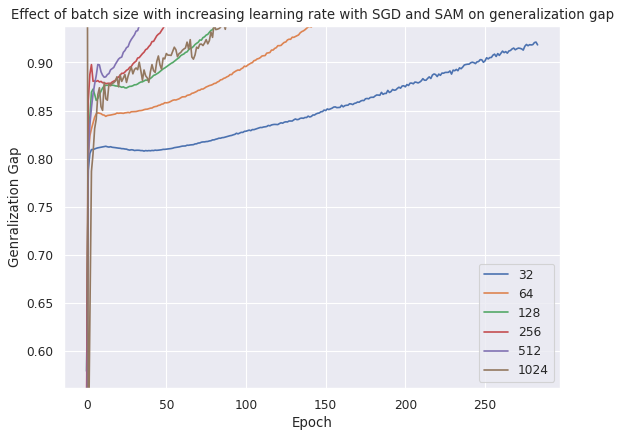

In [1283]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with increasing learning rate with SGD and SAM', 'diff_lr_diff_bs'+'gap')

#### Sharpness

In [1284]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

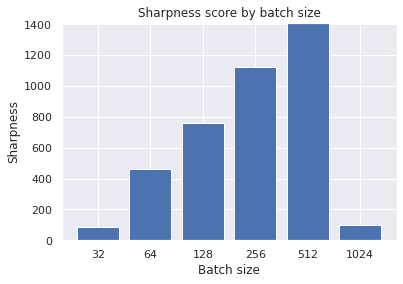

In [1285]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 26.447341918945312
Batch size: 64, distance: 25.183839797973633
Batch size: 128, distance: 21.466157913208008
Batch size: 256, distance: 21.30363655090332
Batch size: 512, distance: 19.352018356323242
Batch size: 1024, distance: 25.156810760498047


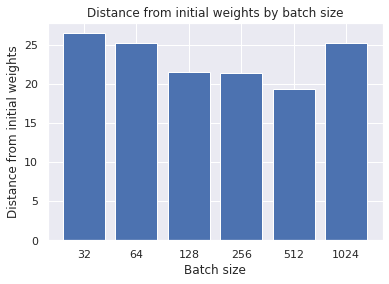

In [1286]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [1287]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.322272986593381
	Converged in 273 epochs
	Overall training time (in seconds) until convergence:  2557.7041692733765
Batch size:  64
	Mean time per epoch:  4.6236502348430575
	Converged in 241 epochs
	Overall training time (in seconds) until convergence:  1114.40460562706
Batch size:  128
	Mean time per epoch:  3.3389033770019356
	Converged in 165 epochs
	Overall training time (in seconds) until convergence:  551.4360527992249
Batch size:  256
	Mean time per epoch:  2.704045535578872
	Converged in 154 epochs
	Overall training time (in seconds) until convergence:  417.66231203079224
Batch size:  512
	Mean time per epoch:  2.2646787826831525
	Converged in 119 epochs
	Overall training time (in seconds) until convergence:  270.00433683395386
Batch size:  1024
	Mean time per epoch:  2.1726669922471045
	Converged in 149 epochs
	Overall training time (in seconds) until convergence:  324.7659332752228


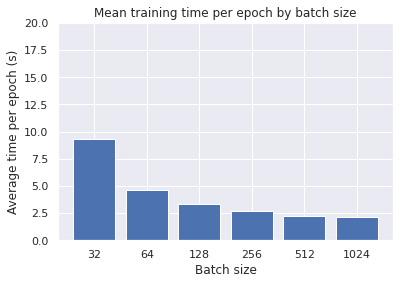

In [1288]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

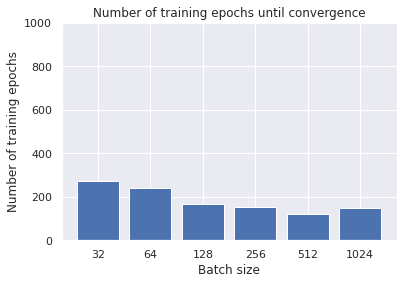

In [1289]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

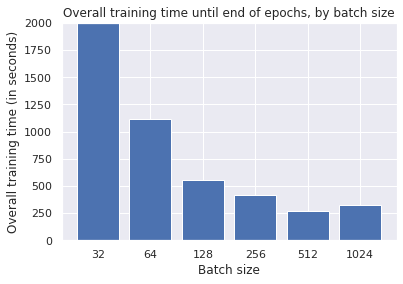

In [1290]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [1291]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### SGD with Momentum + ASAM

In [1292]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'asam')

In [1293]:
state_filename = 'model_diff_lr_diff_bs_sgd_asam_state'

In [1294]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))
        models[key + (batch_size, lr)] = model

In [1295]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))
            initial_weights[key + (batch_size, lr)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1296]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

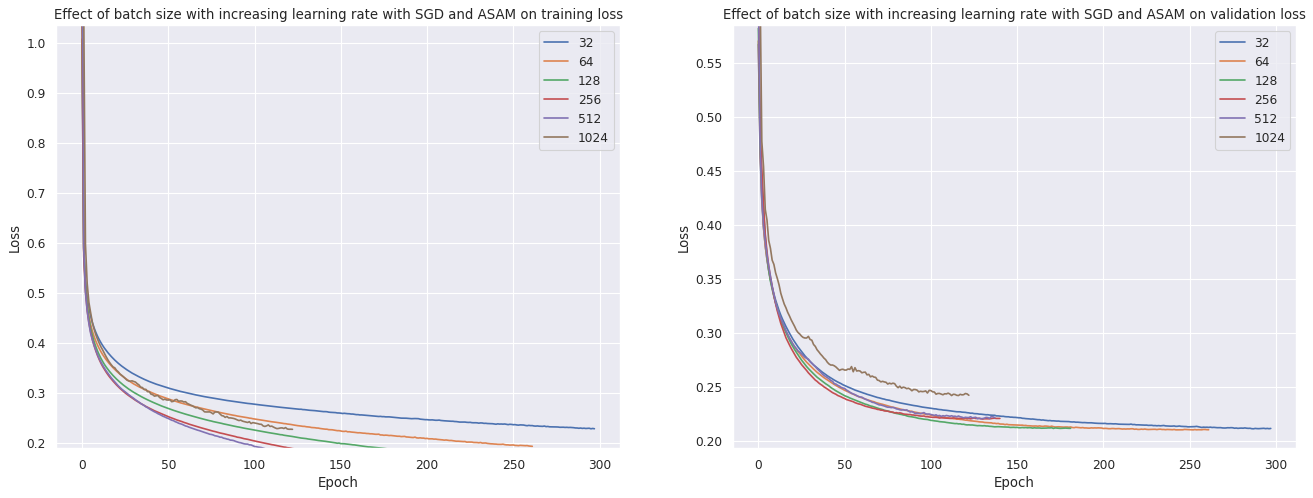

In [1297]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD and ASAM',
                                 'diff_lr_diff_bs_SGD_ASAM')

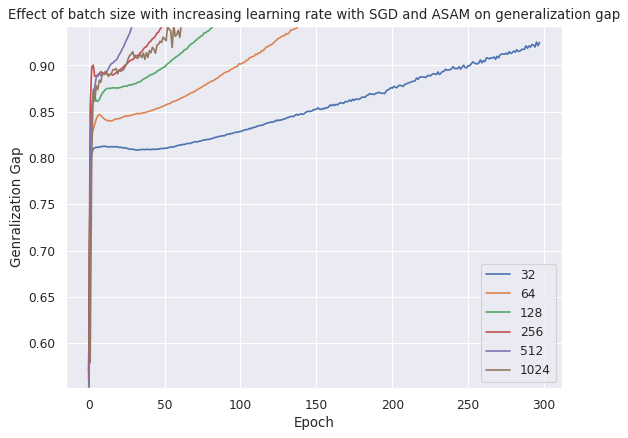

In [1298]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with increasing learning rate with SGD and ASAM', 'diff_lr_diff_bs_SGD_ASAM'+'gap')

#### Sharpness

In [1299]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

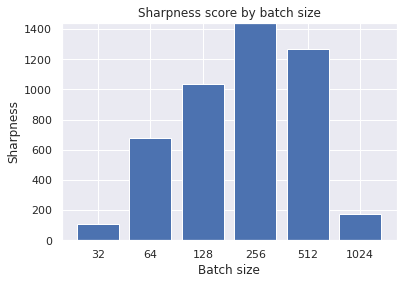

In [1300]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 27.011226654052734
Batch size: 64, distance: 25.659832000732422
Batch size: 128, distance: 21.75313377380371
Batch size: 256, distance: 19.647743225097656
Batch size: 512, distance: 19.889183044433594
Batch size: 1024, distance: 20.665861129760742


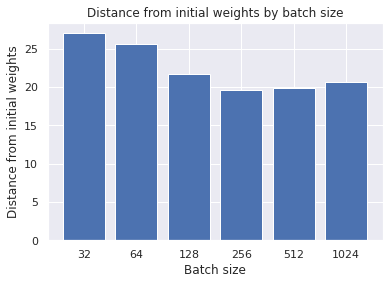

In [1301]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [1302]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  10.06500259181797
	Converged in 287 epochs
	Overall training time (in seconds) until convergence:  2880.150973558426
Batch size:  64
	Mean time per epoch:  4.763403578568961
	Converged in 251 epochs
	Overall training time (in seconds) until convergence:  1192.1550178527832
Batch size:  128
	Mean time per epoch:  3.326995620360741
	Converged in 171 epochs
	Overall training time (in seconds) until convergence:  568.0591926574707
Batch size:  256
	Mean time per epoch:  2.689356770075805
	Converged in 130 epochs
	Overall training time (in seconds) until convergence:  349.3867745399475
Batch size:  512
	Mean time per epoch:  2.322464220765708
	Converged in 127 epochs
	Overall training time (in seconds) until convergence:  294.8970077037811
Batch size:  1024
	Mean time per epoch:  2.06497291626969
	Converged in 112 epochs
	Overall training time (in seconds) until convergence:  231.59186148643494


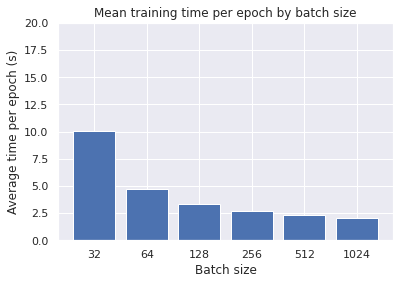

In [1303]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

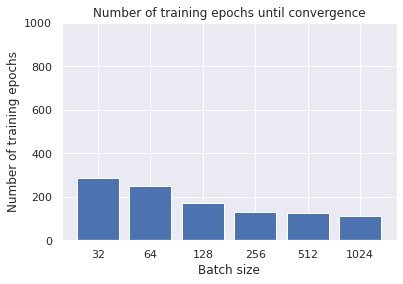

In [1304]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

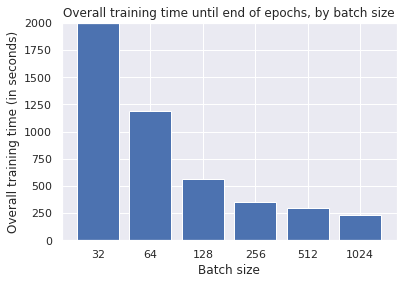

In [1305]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [1306]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM + SAM

In [1307]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'sam')

In [1308]:
state_filename = 'model_diff_lr_diff_bs_adam_sam_state'

In [1309]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))
        models[key + (batch_size, lr)] = model

In [1310]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))
            initial_weights[key + (batch_size, lr)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1311]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

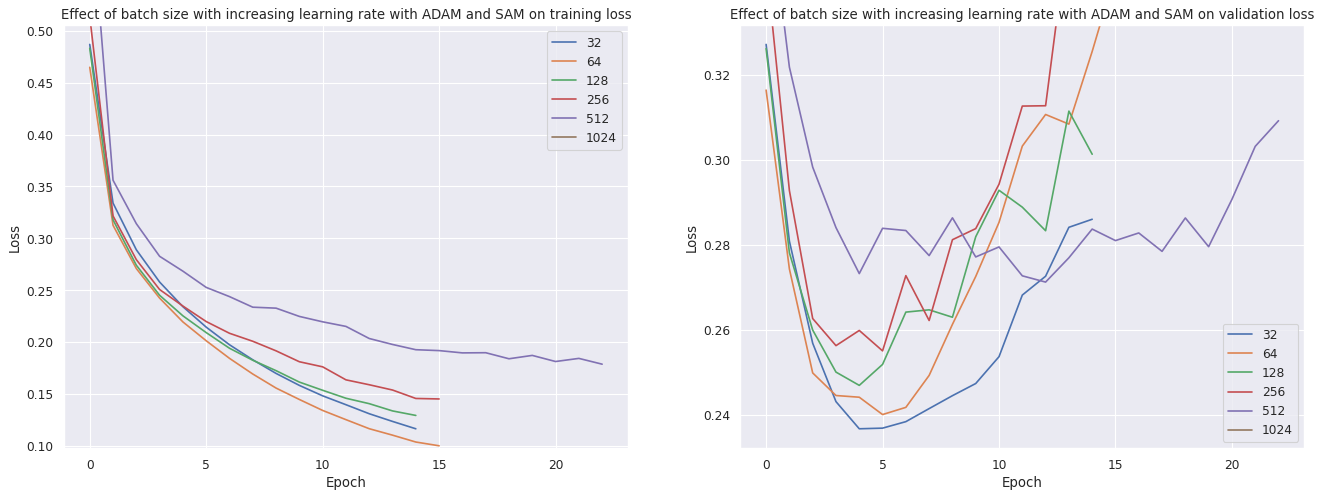

In [1312]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and SAM',
                                 'diff_lr_diff_bs_ADAM_SAM')

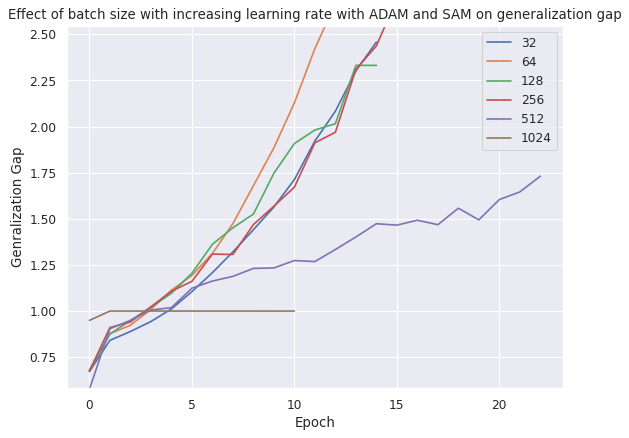

In [1313]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and SAM', 'diff_lr_diff_bs_ADAM_SAM'+'gap')

#### Sharpness

In [1314]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

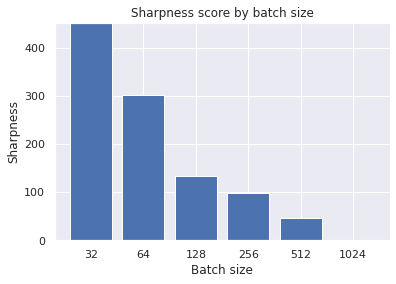

In [1315]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 28.71186065673828
Batch size: 64, distance: 36.340782165527344
Batch size: 128, distance: 37.0580940246582
Batch size: 256, distance: 44.15264129638672
Batch size: 512, distance: 58.24185562133789
Batch size: 1024, distance: 43.10898208618164


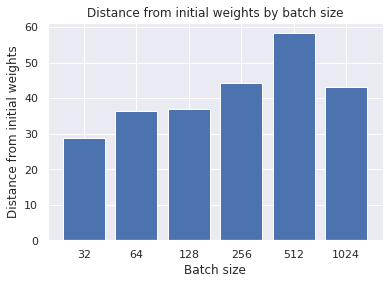

In [1316]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [1317]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.889757982889812
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  39.38583469390869
Batch size:  64
	Mean time per epoch:  4.477881386876106
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  23.004905700683594
Batch size:  128
	Mean time per epoch:  3.2827021916707357
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  13.438693523406982
Batch size:  256
	Mean time per epoch:  2.72330641746521
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  13.733137130737305
Batch size:  512
	Mean time per epoch:  2.3999560812245244
	Converged in 12 epochs
	Overall training time (in seconds) until convergence:  28.86772584915161
Batch size:  1024
	Mean time per epoch:  2.1131736798719927
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


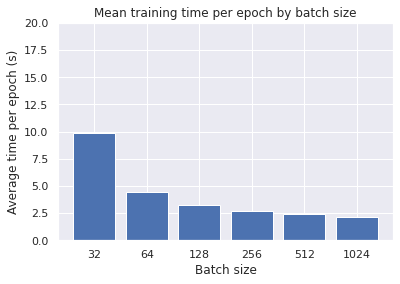

In [1318]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

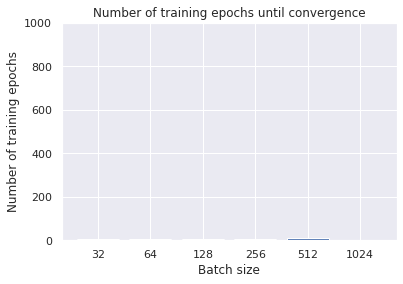

In [1319]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

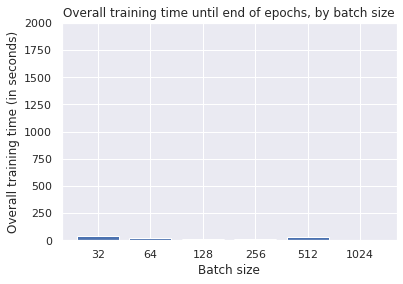

In [1320]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [1321]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## ADAM + ASAM

In [1322]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'asam')

In [1323]:
state_filename = 'model_diff_lr_diff_bs_adam_asam_state'

In [1324]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))
        models[key + (batch_size, lr)] = model

In [1325]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))
            initial_weights[key + (batch_size, lr)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1326]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

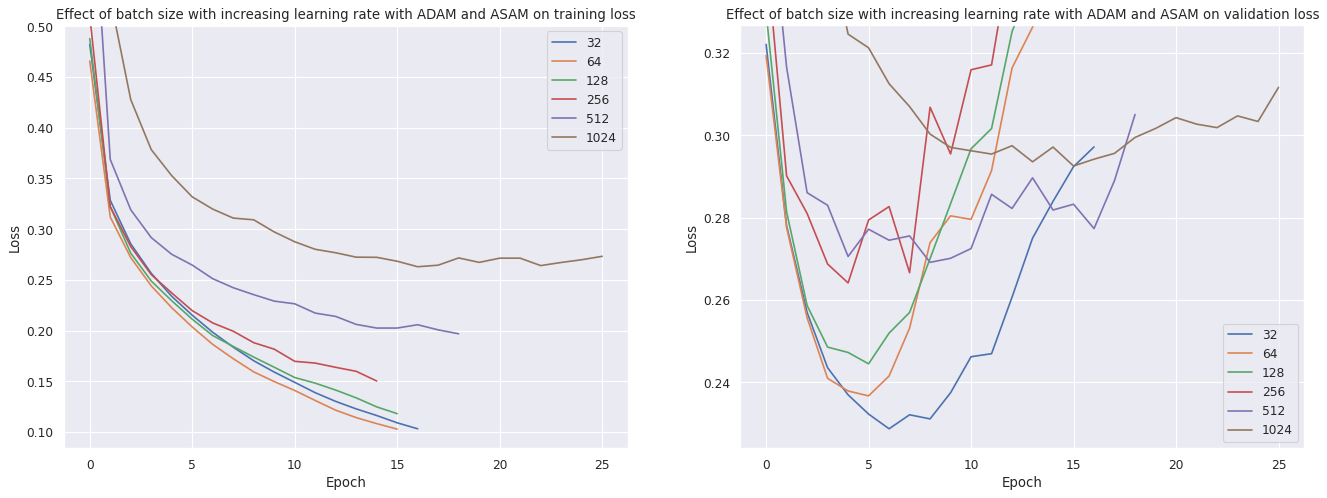

In [1327]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and ASAM',
                                 'diff_lr_diff_bs_ADAM_ASAM')

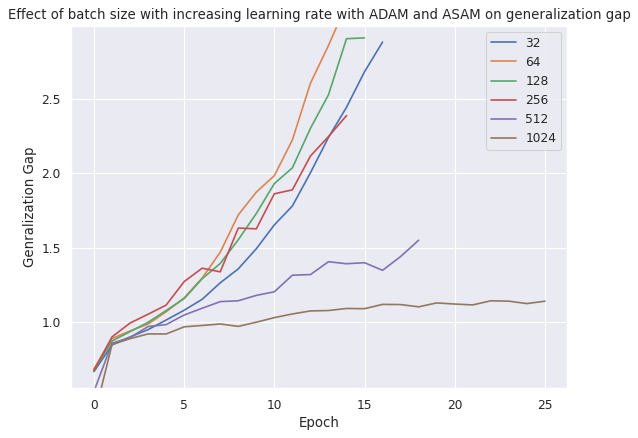

In [1328]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and ASAM', 'diff_lr_diff_bs_ADAM_ASAM'+'gap')

#### Sharpness

In [1329]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

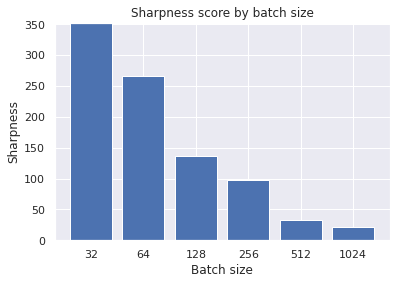

In [1330]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 34.88965606689453
Batch size: 64, distance: 36.210086822509766
Batch size: 128, distance: 40.1136474609375
Batch size: 256, distance: 43.525054931640625
Batch size: 512, distance: 46.98640441894531
Batch size: 1024, distance: 73.37010955810547


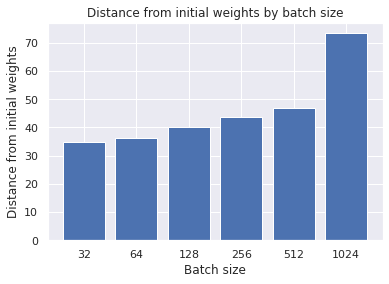

In [1331]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [1332]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.556080537683824
	Converged in 6 epochs
	Overall training time (in seconds) until convergence:  57.914875984191895
Batch size:  64
	Mean time per epoch:  4.549572333693504
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  25.503568410873413
Batch size:  128
	Mean time per epoch:  3.3196712732315063
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  17.0074303150177
Batch size:  256
	Mean time per epoch:  2.80594809850057
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  12.070507049560547
Batch size:  512
	Mean time per epoch:  2.4525947947251168
	Converged in 8 epochs
	Overall training time (in seconds) until convergence:  21.40496826171875
Batch size:  1024
	Mean time per epoch:  2.1545578241348267
	Converged in 15 epochs
	Overall training time (in seconds) until convergence:  33.38535189628601


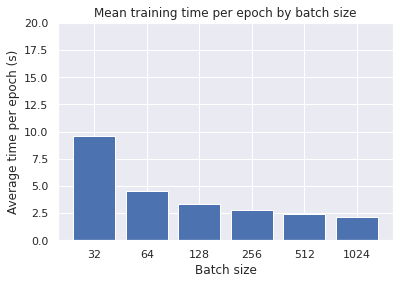

In [1333]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

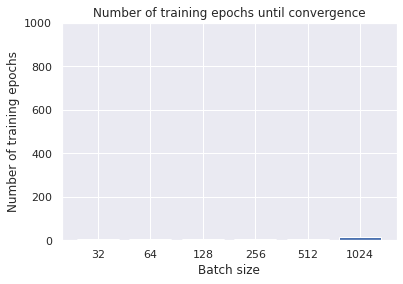

In [1334]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

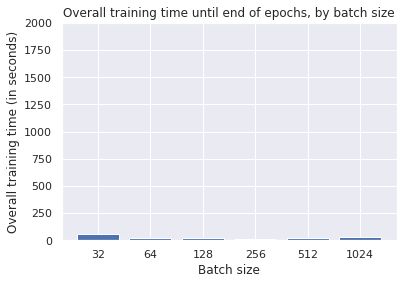

In [1335]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [1336]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## without sharpness aware minimization

### SGD with Momentum

In [1337]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'SGD', 'none')

In [1338]:
state_filename = 'model_diff_lr_diff_bs_sgd_state'

In [1339]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))
        models[key + (batch_size, lr)] = model

In [1340]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))
            initial_weights[key + (batch_size, lr)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1341]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

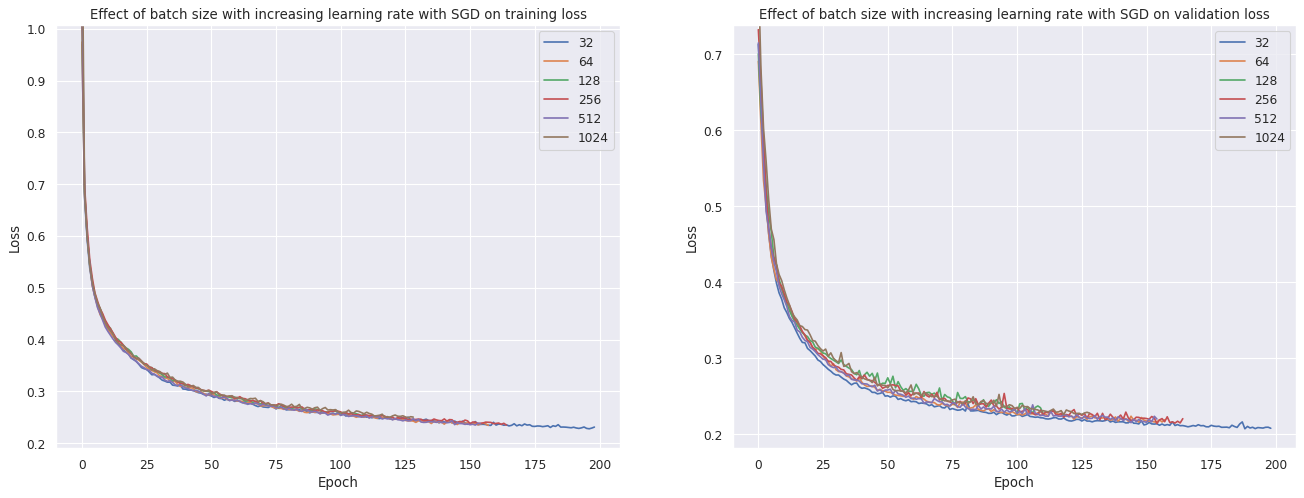

In [1342]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD',
                                 'diff_lr_diff_bs_SGD_NONE')

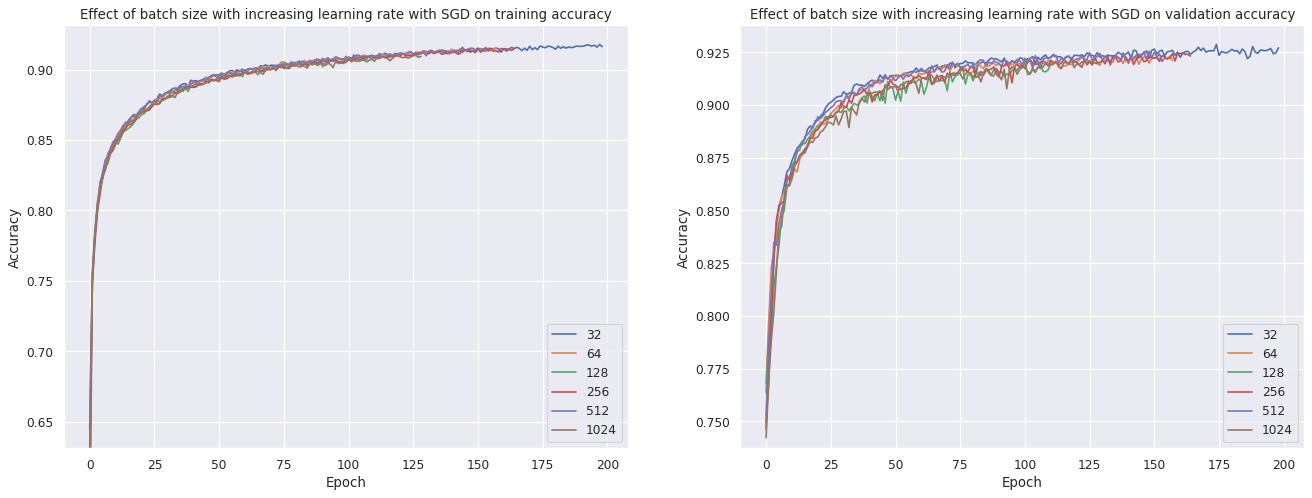

In [1343]:
visualization.plot_accuracies_by_param(models_states[key], 'batch size with increasing learning rate with SGD',
                                 'diff_lr_diff_bs_SGD_NONE')

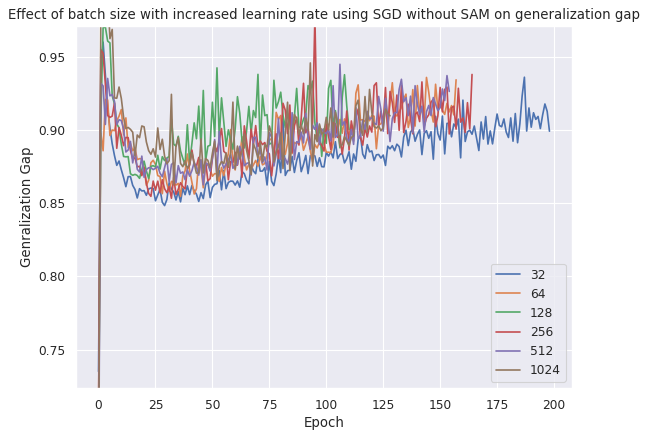

In [1344]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with increased learning rate using SGD without SAM', 'increased_lr_diff_bs_SGD_SAM_gap')

#### Sharpness

In [1345]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

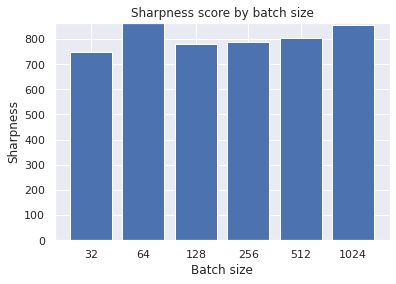

In [1346]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 19.155075073242188
Batch size: 64, distance: 17.76386070251465
Batch size: 128, distance: 15.697810173034668
Batch size: 256, distance: 18.111623764038086
Batch size: 512, distance: 17.731380462646484
Batch size: 1024, distance: 16.80396842956543


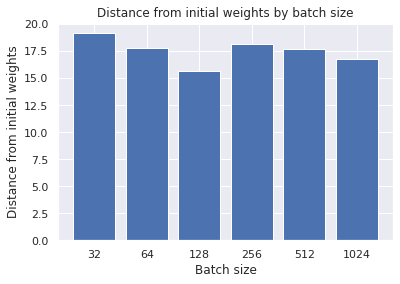

In [1347]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [1348]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.025738989288484
	Converged in 188 epochs
	Overall training time (in seconds) until convergence:  947.3867819309235
Batch size:  64
	Mean time per epoch:  2.719065377983866
	Converged in 147 epochs
	Overall training time (in seconds) until convergence:  400.32065534591675
Batch size:  128
	Mean time per epoch:  1.96880900322854
	Converged in 100 epochs
	Overall training time (in seconds) until convergence:  196.83333706855774
Batch size:  256
	Mean time per epoch:  1.6305112477504846
	Converged in 154 epochs
	Overall training time (in seconds) until convergence:  251.426362991333
Batch size:  512
	Mean time per epoch:  1.3862650317530478
	Converged in 144 epochs
	Overall training time (in seconds) until convergence:  199.55765295028687
Batch size:  1024
	Mean time per epoch:  1.2488482349602752
	Converged in 118 epochs
	Overall training time (in seconds) until convergence:  147.12133741378784


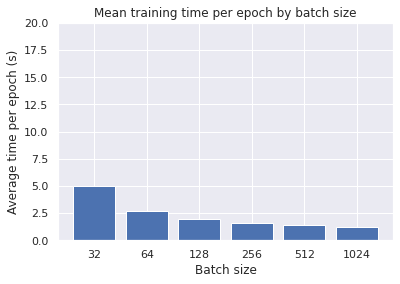

In [1349]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

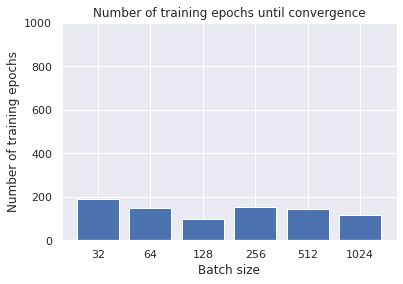

In [1350]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

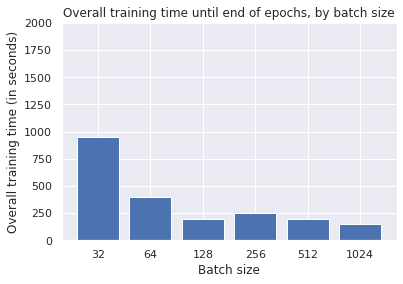

In [1351]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [1352]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM

In [1353]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'none')

In [1354]:
state_filename = 'model_diff_lr_diff_bs_adam_state'

In [1355]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))
        models[key + (batch_size, lr)] = model

In [1356]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))
            initial_weights[key + (batch_size, lr)] = copy.deepcopy(model.get_weights())
            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            ml_utils.save_initial_weights_dict(initial_weights)

In [1357]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

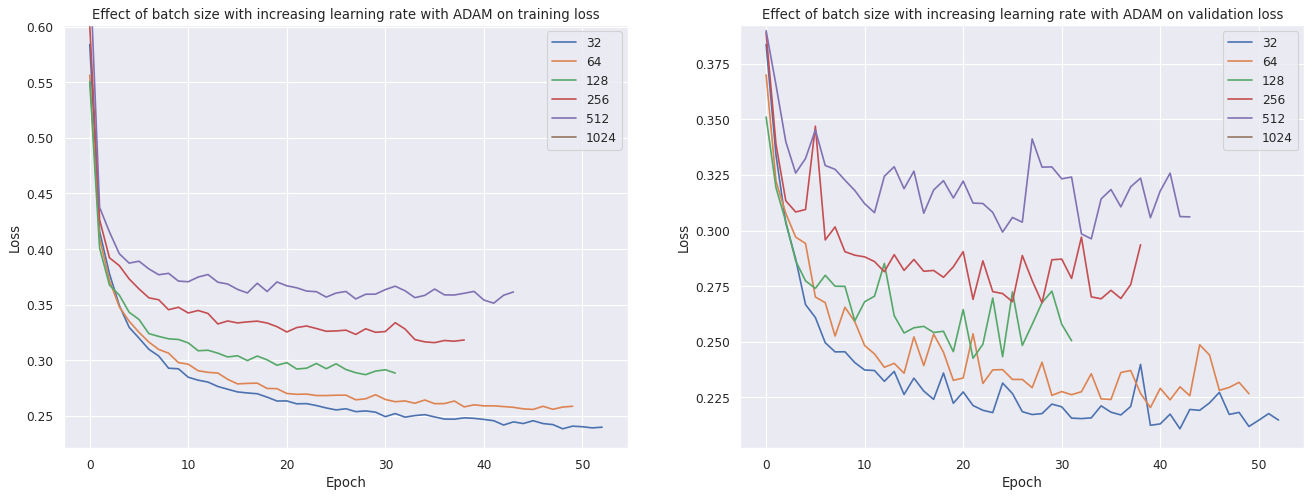

In [1358]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM',
                                 'diff_lr_diff_bs_ADAM_NONE')

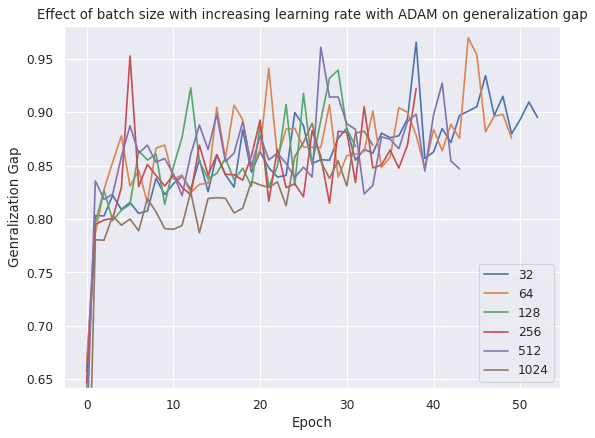

In [1359]:
visualization.plot_generalization_gap_by_param(models_states[key], 'batch size with increasing learning rate with ADAM', 'diff_lr_diff_bs_ADAM_NONE'+'gap')

#### Sharpness

In [1360]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

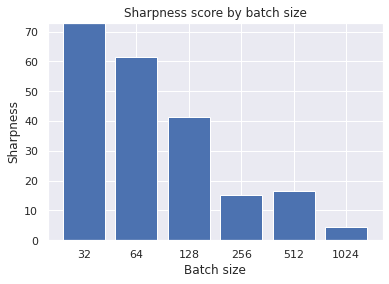

In [1361]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 81.58409118652344
Batch size: 64, distance: 97.68184661865234
Batch size: 128, distance: 82.58474731445312
Batch size: 256, distance: 105.24707794189453
Batch size: 512, distance: 121.67340087890625
Batch size: 1024, distance: 67.44109344482422


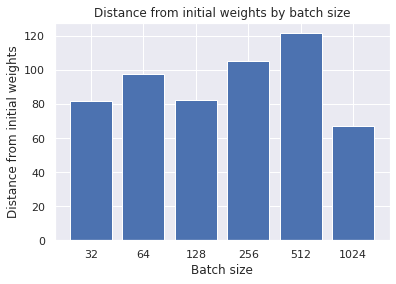

In [1362]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [1363]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.17829818095801
	Converged in 42 epochs
	Overall training time (in seconds) until convergence:  216.91622805595398
Batch size:  64
	Mean time per epoch:  2.9517298793792723
	Converged in 39 epochs
	Overall training time (in seconds) until convergence:  113.91619539260864
Batch size:  128
	Mean time per epoch:  2.1449503749608994
	Converged in 21 epochs
	Overall training time (in seconds) until convergence:  45.97998404502869
Batch size:  256
	Mean time per epoch:  1.7102440503927379
	Converged in 28 epochs
	Overall training time (in seconds) until convergence:  48.8526246547699
Batch size:  512
	Mean time per epoch:  1.3939615975726733
	Converged in 33 epochs
	Overall training time (in seconds) until convergence:  46.22453808784485
Batch size:  1024
	Mean time per epoch:  1.236051643595976
	Converged in 23 epochs
	Overall training time (in seconds) until convergence:  28.622080326080322


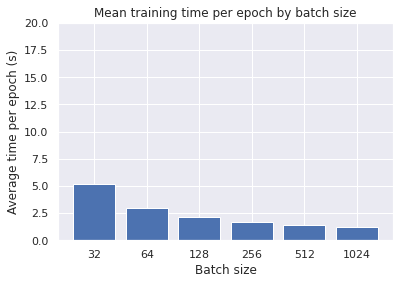

In [1364]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

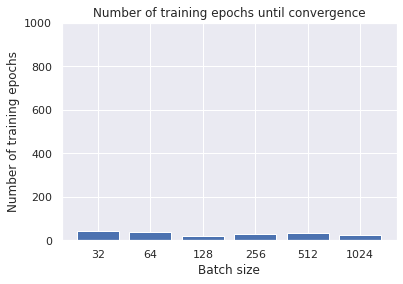

In [1365]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

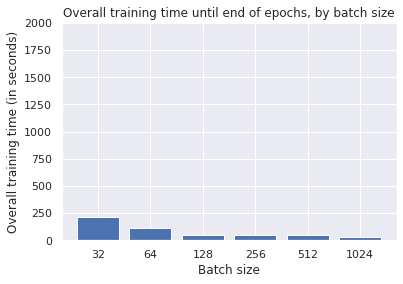

In [1366]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

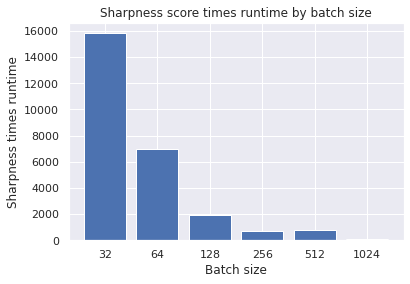

In [1367]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [1368]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 1495.9697223367316,
 ('fixed', 'sgd', 'sam', 64): 2108.1054789797445,
 ('fixed', 'sgd', 'sam', 128): 3441.863265352294,
 ('fixed', 'sgd', 'sam', 256): 3816.6512521542195,
 ('fixed', 'sgd', 'sam', 512): 3765.510547038893,
 ('fixed', 'sgd', 'sam', 1024): 4611.659402653669,
 ('fixed', 'sgd', 'asam', 32): 114.70426368521629,
 ('fixed', 'sgd', 'asam', 64): 567.711009122984,
 ('fixed', 'sgd', 'asam', 128): 1247.631680314687,
 ('fixed', 'sgd', 'asam', 256): 2058.310647990916,
 ('fixed', 'sgd', 'asam', 512): 2762.0373197698873,
 ('fixed', 'sgd', 'asam', 1024): 3830.6471530901504,
 ('fixed', 'adam', 'sam', 32): 339.5464594642713,
 ('fixed', 'adam', 'sam', 64): 427.6690240934567,
 ('fixed', 'adam', 'sam', 128): 843.708444491658,
 ('fixed', 'adam', 'sam', 256): 1298.0106772782028,
 ('fixed', 'adam', 'sam', 512): 1715.7475049492089,
 ('fixed', 'adam', 'sam', 1024): 1493.9961018343301,
 ('fixed', 'adam', 'asam', 32): 82.85575924940814,
 ('fixed', 'adam', 'asam', 64): 2